In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import librosa
import soundfile as sf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from keras_self_attention import SeqSelfAttention 
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
df=pd.read_csv(r'Respiratory_Sound_Database\diagnosis_details.csv')
df.head()

,patient_id,diagnosis,recording_index,chest_location,acquisition_mode,recording_equipment
0,101,URTI,1b1,Al,sc,Meditron
1,101,URTI,1b1,Pr,sc,Meditron
2,102,Healthy,1b1,Ar,sc,Meditron
3,103,Asthma,2b2,Ar,mc,LittC2SE
4,104,COPD,1b1,Al,sc,Litt3200


In [5]:
df.isnull().sum()

patient_id             0
diagnosis              0
recording_index        0
chest_location         0
acquisition_mode       0
recording_equipment    0
dtype: int64

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   patient_id           920 non-null    int64 
 1   diagnosis            920 non-null    object
 2   recording_index      920 non-null    object
 3   chest_location       920 non-null    object
 4   acquisition_mode     920 non-null    object
 5   recording_equipment  920 non-null    object
dtypes: int64(1), object(5)
memory usage: 43.2+ KB


In [7]:
#for prediction we only need first wo columns
df=df.iloc[:,:2]
df.head(1)

,patient_id,diagnosis
0,101,URTI


In [8]:
count=df['diagnosis'].value_counts()
count

COPD              793
Pneumonia          37
Healthy            35
URTI               23
Bronchiectasis     16
Bronchiolitis      13
LRTI                2
Asthma              1
Name: diagnosis, dtype: int64

(array([0, 1, 2, 3, 4, 5, 6, 7]),
 [Text(0, 0, 'COPD'),
  Text(1, 0, 'Pneumonia'),
  Text(2, 0, 'Healthy'),
  Text(3, 0, 'URTI'),
  Text(4, 0, 'Bronchiectasis'),
  Text(5, 0, 'Bronchiolitis'),
  Text(6, 0, 'LRTI'),
  Text(7, 0, 'Asthma')])

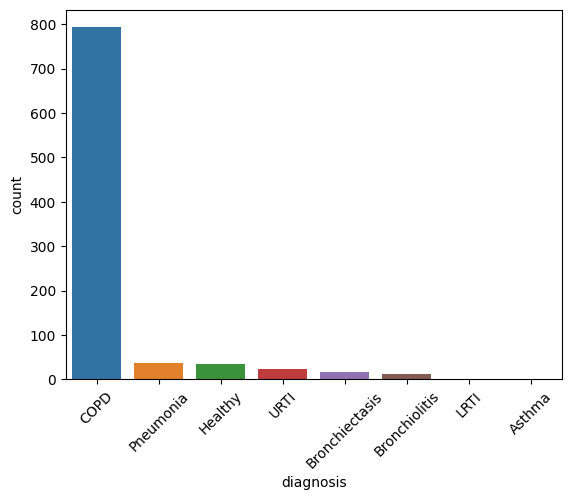

In [9]:
#we have to deal with the imbalance in our dataset
sns.countplot(x='diagnosis',data=df,order=count.index)
plt.xticks(rotation=45)

In [10]:
audio_files=glob.glob(r'Respiratory_Sound_Database\audio_and_txt_files\*.wav')
print(os.path.basename(audio_files[0]).split('_')[0])

101


In [11]:
#new_file_name = f"{os.path.splitext(audio_files[0])[0]}_aug_{np.random.randint(1000)}{os.path.splitext(audio_files[0])[1]}"
new_file_name=f"{os.path.splitext(audio_files[0])[0]}_aug_{4}{os.path.splitext(audio_files[0])[1]}"
print(new_file_name)

Respiratory_Sound_Database\audio_and_txt_files\101_1b1_Al_sc_Meditron_aug_4.wav


## Data Augmantation

In [12]:
# we will apply four types of augmentation techniques
def add_noise(data,noise_level=0.005):
    noise=np.random.random(len(data))
    augmented_data=data+noise*noise_level
    #Cast baskc data to the same data type
    augmented_data=augmented_data.astype(type(data[0]))
    return augmented_data


def stretch(data,r=1.5):
    return librosa.effects.time_stretch(data,rate=r)


def change_pitch(data,sample_rate,semitones=2):
    return librosa.effects.pitch_shift(data,sr=sample_rate,n_steps=semitones)

def change_volume(data,factor=0.5):
    return data*factor

In [ ]:
# augmentations = np.random.choice(['noise', 'stretch', 'pitch', 'volume'], size=2, replace=False)
# augmentations
augmentation_multipliers = {cls: int(np.ceil(target_samples / count)) for cls, count in class_distribution.items()}
augmentation_multipliers

In [13]:
class_distribution=count.to_dict()

#target number of samples for each class
target_samples=max(class_distribution.values())

#calculate the number of samples to add for each class
augmentation_multipliers={cls: int(np.ceil(target_samples / count)) for cls, count in class_distribution.items()}
#augrmantation_factor={k:target_samples-v for k,v in class_distribution.items()}
augmentation_multipliers

{'COPD': 1,
 'Pneumonia': 22,
 'Healthy': 23,
 'URTI': 35,
 'Bronchiectasis': 50,
 'Bronchiolitis': 61,
 'LRTI': 397,
 'Asthma': 793}

In [14]:
#function to augment the data
def augment_data(file_path,augmentations):
    y,sr=librosa.load(file_path,sr=None)
    augmented_data=y
    for augmentation in augmentations:
        if augmentation=='noise':
            augmented_data=add_noise(augmented_data)
        if augmentation=='stretch':
            augmented_data=stretch(augmented_data)
        if augmentation=='pitch':
            augmented_data=change_pitch(augmented_data,sr)
        if augmentation=='volume':
            augmented_data=change_volume(augmented_data)
    return augmented_data,sr

In [15]:
df2=pd.read_csv(r'Respiratory_Sound_Database\patient_diagnosis.csv',names=['patient_id','diagnosis'])
df2.head()

,patient_id,diagnosis
0,101,URTI
1,102,Healthy
2,103,Asthma
3,104,COPD
4,105,URTI


In [16]:
new_data = augment_data(audio_files[0], ['pitch', 'volume'])
new_data


(array([ 0.04259979,  0.04973283,  0.04669041, ..., -0.01506342,
        -0.01344411, -0.01644927], dtype=float32),
 44100)

In [17]:
#creating new files with augmented data
def augment_and_label_audio(file_path,df,augmentation_multipliers):
    for f in audio_files:
        patient_id=os.path.basename(f).split('_')[0]
        diagnosis=df[df['patient_id']==int(patient_id)]['diagnosis'].values[0]
        if(diagnosis!='COPD'):
            multiplier=augmentation_multipliers[diagnosis]
            
            for i in range(multiplier):
                augmentation=np.random.choice(['noise','stretch','pitch','volume'],size=2,replace=False)
                new_data,sr=augment_data(f,augmentation)
                new_file_name=f"{os.path.splitext(f)[0]}_aug_{i}{os.path.splitext(f)[1]}"
                sf.write(new_file_name,new_data,sr)
        

In [58]:
#augment_and_label_audio(audio_files,df2,augmentation_multipliers)

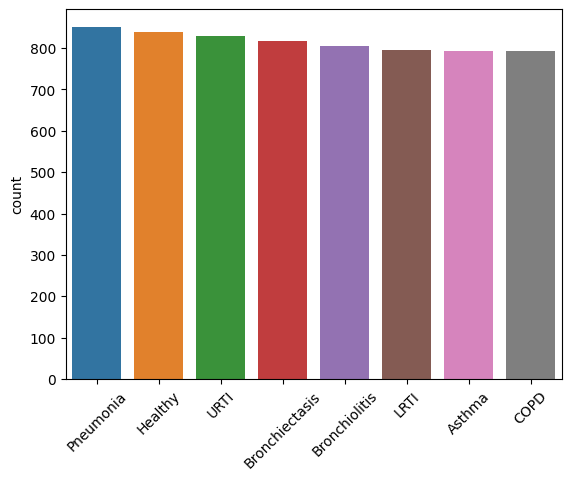

In [20]:
#checking values in new data
audio_files2=glob.glob(r'Respiratory_Sound_Database\audio_and_txt_files\*.wav')
labels2=[]
max_pad_len=926
for i in audio_files2:
    labels2.append(extract_label(i,df2))
labels2_series = pd.Series(labels2)
sns.countplot(x=labels2_series, order=labels2_series.value_counts().index)
plt.xticks(rotation=45)
plt.show()

## Feature extraction

In [19]:
#function for extracting class labels
def extract_label(file,df):
    id=os.path.basename(file).split('_')[0]
    label=df[df['patient_id']==int(id)]['diagnosis'].values[0]
    return label


#function for extracting mfcc features
def feature_extraction(file,max_pad_len,n_features):
# Load the .wav file
    audio, sample_rate = librosa.load(file)
    # Extract the MFCC features
    mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate,n_mfcc=n_features)
    
    # If the array is shorter than max_pad_len, pad it with zeros
    if (mfccs.shape[1] < max_pad_len):
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    
    # If the array is longer than max_pad_len, truncate it
    elif (mfccs.shape[1] > max_pad_len):
        mfccs = mfccs[:, :max_pad_len]
        
    return mfccs


In [21]:
mfccs_features=[]
length=[]
labels=[]
max_pad_len=926
for i in audio_files2:
    mfccs=feature_extraction(i,max_pad_len,52)
    mfccs_features.append(mfccs)
    labels.append(extract_label(i,df2))
    length.append(mfccs.shape[1])

In [22]:
#check length size of mfccs_features
print(f'max length is {max(length)} min length is {min(length)} average length is {np.mean(length)}')
#max length is 3713 min length is 339 average length is 926.2423913043478
#we will pad the mfccs_features to 926

max length is 926 min length is 926 average length is 926.0


In [22]:
#converting fatures and labels to numpy arrays
mfccs_features=np.array(mfccs_features)
labels=np.array(labels)
print(mfccs_features.shape)
print(labels.shape)


(6524, 52, 926)
(6524,)


### Model 

In [23]:
#encoding the labels
# label_encoder=LabelEncoder()
# labels=label_encoder.fit_transform(labels)
# one_hot_labels=to_categorical(labels,num_classes=8)
# one_hot_labels


array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [24]:
#creating model usign LSTM and attention cnn
model=Sequential([
    Input(shape=(52,926)),
    
    Conv1D(64,5,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    Conv1D(128,3,padding='same',activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    
    # LSTM layers with return_sequences=True to keep temporal dimension
    LSTM(128, return_sequences=True),
    Dropout(0.5),
    
    # Attention Layer
    SeqSelfAttention(attention_activation='sigmoid'),
    
    # Additional LSTM Layer
    LSTM(128),
    Dropout(0.5),
    
    # Dense Layers for Classification
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 52, 64)            296384    
                                                                 
 batch_normalization (BatchN  (None, 52, 64)           256       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 26, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 26, 128)           24704     
                                                                 
 batch_normalization_1 (Batc  (None, 26, 128)          512       
 hNormalization)                                                 
                                                        

In [25]:
# Split the dataset into training, validation, and test sets
X_train,X_test,y_train,y_test=train_test_split(mfccs_features,labels,test_size=0.2,random_state=0)

#early stopping to prevent overfitting
early_stopping=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True)

In [26]:
#applying one_hot encoding
encoder=OneHotEncoder(sparse=False,handle_unknown='ignore')
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

In [27]:
history=model.fit(
    X_train,y_train_encoded,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
    )

Epoch 1/100
131/131 [==============================] - 29s 117ms/step - loss: 1.7708 - accuracy: 0.2996 - val_loss: 1.2714 - val_accuracy: 0.5431
Epoch 2/100
131/131 [==============================] - 13s 100ms/step - loss: 1.3509 - accuracy: 0.4496 - val_loss: 1.2882 - val_accuracy: 0.4923
Epoch 3/100
131/131 [==============================] - 13s 103ms/step - loss: 1.0745 - accuracy: 0.5466 - val_loss: 1.1809 - val_accuracy: 0.5067
Epoch 4/100
131/131 [==============================] - 16s 122ms/step - loss: 0.9616 - accuracy: 0.6031 - val_loss: 0.8664 - val_accuracy: 0.6437
Epoch 5/100
131/131 [==============================] - 13s 96ms/step - loss: 0.7845 - accuracy: 0.6572 - val_loss: 0.5647 - val_accuracy: 0.7328
Epoch 6/100
131/131 [==============================] - 15s 113ms/step - loss: 0.6224 - accuracy: 0.7190 - val_loss: 1.3327 - val_accuracy: 0.5460
Epoch 7/100
131/131 [==============================] - 13s 102ms/step - loss: 0.5282 - accuracy: 0.7535 - val_loss: 0.7462 - 

In [29]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {test_loss}\nTest Accuracy: {test_accuracy}")

41/41 [==============================] - 1s 30ms/step - loss: 0.1289 - accuracy: 0.9693
Test Loss: 0.12888048589229584
Test Accuracy: 0.969348669052124


In [32]:
# Assuming model is your trained Keras model
predictions = model.predict(X_test)
predictions = np.argmax(predictions, axis=1)  # Convert one-hot encoded predictions to class labels

# If y_test is one-hot encoded, convert it back to class labels
y_test_labels = np.argmax(y_test_encoded, axis=1)

# Get class names
class_names = encoder.categories_[0]

# Generate classification report
print(classification_report(predictions, y_test_labels, target_names=class_names))

41/41 [==============================] - 1s 25ms/step
                precision    recall  f1-score   support

        Asthma       1.00      1.00      1.00       160
Bronchiectasis       1.00      0.98      0.99       166
 Bronchiolitis       1.00      0.98      0.99       148
          COPD       0.89      1.00      0.94       138
       Healthy       0.99      0.88      0.93       205
          LRTI       1.00      1.00      1.00       147
     Pneumonia       1.00      0.97      0.98       188
          URTI       0.88      0.99      0.93       153

      accuracy                           0.97      1305
     macro avg       0.97      0.97      0.97      1305
  weighted avg       0.97      0.97      0.97      1305



41/41 [==============================] - 2s 36ms/step


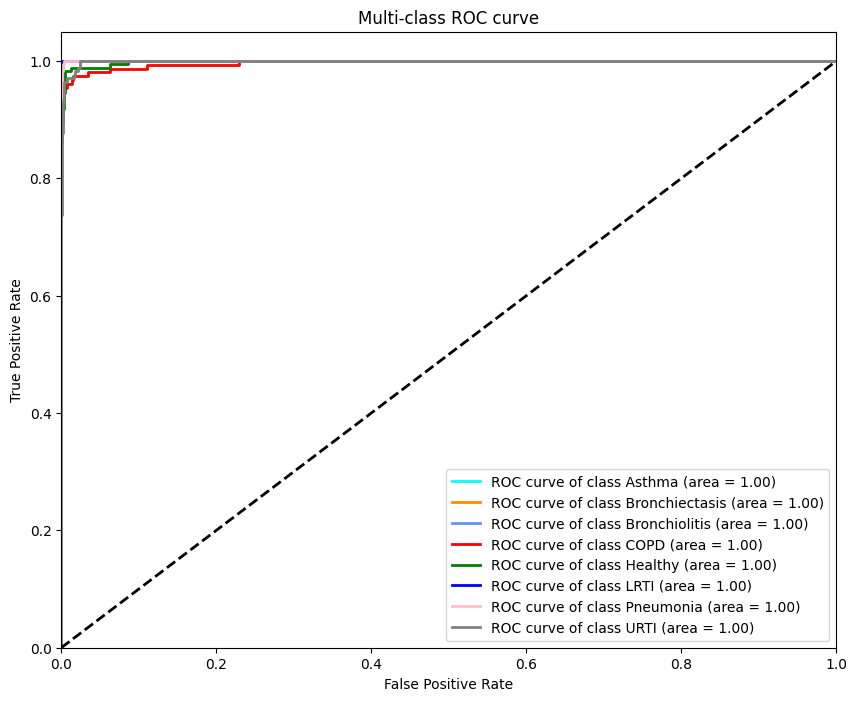

In [35]:
probabilities = model.predict(X_test)


y_test_binarized = label_binarize(y_test_labels, classes=[0,1,2,3,4,5,6,7])
# Compute ROC curve and ROC area for each class
n_classes = len(class_names)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(10, 8))

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'blue', 'pink', 'gray'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC curve')
plt.legend(loc="lower right")
plt.show()

In [34]:
y_test_labels

array([7, 6, 4, ..., 6, 5, 6], dtype=int64)